In [3]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hamming_loss, make_scorer # type: ignore
from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator, MACCSkeys
import numpy as np

# Input preparation

## Read fingerprint file and experimental file

In [4]:
# Load the data
fingerprints = pd.read_csv(
    "https://raw.githubusercontent.com/HauserGroup/PsyModTraining/refs/heads/main/data/PsychLight/PsychLight_MACCS_fingerprints.csv"
)
labels = pd.read_csv("https://raw.githubusercontent.com/HauserGroup/PsyModTraining/refs/heads/main/data/PsychLight/PsychLight_TrainingSet.csv")
print(fingerprints.head())
print(labels['Class'].head())

X = fingerprints.drop(columns=['ID'])
y = labels['Class']

          ID  0  1  2  3  4  5  6  7  8  ...  157  158  159  160  161  162  \
0       5-HT  0  0  0  0  0  0  0  0  0  ...    1    1    0    1    1    1   
1        DMT  0  0  0  0  0  0  0  0  0  ...    0    1    0    1    1    1   
2  25CN-NBOH  0  0  0  0  0  0  0  0  0  ...    1    1    1    1    1    1   
3        LSD  0  0  0  0  0  0  0  0  0  ...    0    1    0    1    1    1   
4  N-Me-5-HT  0  0  0  0  0  0  0  0  0  ...    1    1    0    1    1    1   

   163  164  165  166  
0    1    1    1    0  
1    1    0    1    0  
2    1    1    1    0  
3    1    1    1    0  
4    1    1    1    0  

[5 rows x 168 columns]
0    1
1    1
2    1
3    1
4    1
Name: Class, dtype: int64


## Training

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Optuna

In [6]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, jaccard_score
from sklearn.metrics import (
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# define the objective function
def objective(trial):
    # define the hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 10, 500)
    max_depth = trial.suggest_int("max_depth", 5, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    # max_features = trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    
    # create a random forest classifier with the specified hyperparameters
    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        # max_features=max_features,
        bootstrap=bootstrap,
        random_state=42
    )
    
    # use cross-validation to evaluate the model
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=cv, scoring='accuracy')
    
    # return the mean cross-validation score
    return cv_scores.mean()

# use Optuna to optimize the hyperparameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200) 

# output the best hyperparameters   
print("Best Hyperparameters:", study.best_params)

# train a random forest classifier with the best hyperparameters
best_params = study.best_params
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# make predictions on the test set
y_test_pred = best_rf_classifier.predict(X_test)
y_test_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]  # get the probabilities for the positive class




/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-12-06 14:04:32,746] A new study created in memory with name: no-name-4b7bea23-0975-4c55-b8ee-423e5ec7e44e
[I 2024-12-06 14:04:33,348] Trial 0 finished with value: 0.8071428571428572 and parameters: {'n_estimators': 275, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 0.8071428571428572.
[I 2024-12-06 14:04:34,428] Trial 1 finished with value: 0.7285714285714286 and parameters: {'n_estimators': 319, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 0 with value: 0.8071428571428572.
[I 2024-12-06 14:04:35,371] Trial 2 finished with value: 0.7785714285714287 and parameters: {'n_estimators': 296

Best Hyperparameters: {'n_estimators': 417, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}



--- Training Set Metrics ---
Accuracy: 0.95
F1 Score: 0.95
ROC-AUC Score: 0.99
Precision: 0.95
Recall: 0.95
Cohen's Kappa: 0.86
Matthews Correlation Coefficient (MCC): 0.86
Specificity: 0.96
True Negatives (TN): 26
False Positives (FP): 1
False Negatives (FN): 1
True Positives (TP): 9

--- Test Set Metrics ---
Accuracy: 0.71
F1 Score: 0.71
ROC-AUC Score: 0.75
Precision: 0.71
Recall: 0.71
Cohen's Kappa: 0.39
Matthews Correlation Coefficient (MCC): 0.49
Specificity: 1.00
True Negatives (TN): 9
False Positives (FP): 0
False Negatives (FN): 5
True Positives (TP): 3


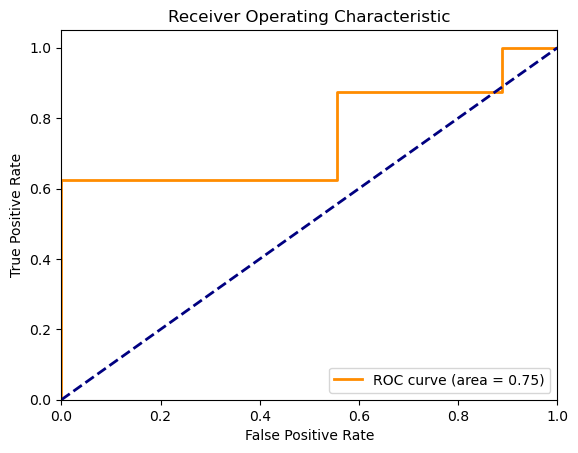

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    confusion_matrix,
    cohen_kappa_score,
    matthews_corrcoef,
)

# train the model
best_rf_classifier.fit(X_train, y_train)

# make predictions on the training set
y_train_pred = best_rf_classifier.predict(X_train)
y_train_pred_proba = best_rf_classifier.predict_proba(X_train)[
    :, 1
]  # get the probabilities for the positive class

# make predictions on the test set
y_test_pred = best_rf_classifier.predict(X_test)
y_test_pred_proba = best_rf_classifier.predict_proba(X_test)[
    :, 1
]  # get the probabilities for the positive class

# calculate metrics for the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average="micro")
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_precision = precision_score(y_train, y_train_pred, average="micro")
train_recall = recall_score(y_train, y_train_pred, average="micro")
train_cohen_kappa = cohen_kappa_score(y_train, y_train_pred)
train_mcc = matthews_corrcoef(y_train, y_train_pred)

# confusion matrix for the training set
train_tn, train_fp, train_fn, train_tp = confusion_matrix(y_train, y_train_pred).ravel()
train_specificity = train_tn / (train_tn + train_fp)

# calculate metrics for the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average="micro")
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
test_precision = precision_score(y_test, y_test_pred, average="micro")
test_recall = recall_score(y_test, y_test_pred, average="micro")
test_cohen_kappa = cohen_kappa_score(y_test, y_test_pred)
test_mcc = matthews_corrcoef(y_test, y_test_pred)

# confusion matrix for the test set
test_tn, test_fp, test_fn, test_tp = confusion_matrix(y_test, y_test_pred).ravel()
test_specificity = test_tn / (test_tn + test_fp)

# print metrics for the training set
print("\n--- Training Set Metrics ---")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"F1 Score: {train_f1:.2f}")
print(f"ROC-AUC Score: {train_roc_auc:.2f}")
print(f"Precision: {train_precision:.2f}")
print(f"Recall: {train_recall:.2f}")
print(f"Cohen's Kappa: {train_cohen_kappa:.2f}")
print(f"Matthews Correlation Coefficient (MCC): {train_mcc:.2f}")
print(f"Specificity: {train_specificity:.2f}")
print(f"True Negatives (TN): {train_tn}")
print(f"False Positives (FP): {train_fp}")
print(f"False Negatives (FN): {train_fn}")
print(f"True Positives (TP): {train_tp}")

# print metrics for the test set
print("\n--- Test Set Metrics ---")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"F1 Score: {test_f1:.2f}")
print(f"ROC-AUC Score: {test_roc_auc:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"Cohen's Kappa: {test_cohen_kappa:.2f}")
print(f"Matthews Correlation Coefficient (MCC): {test_mcc:.2f}")
print(f"Specificity: {test_specificity:.2f}")
print(f"True Negatives (TN): {test_tn}")
print(f"False Positives (FP): {test_fp}")
print(f"False Negatives (FN): {test_fn}")
print(f"True Positives (TP): {test_tp}")

# Plot ROC curve for the test set
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()


## GridSearchCV

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


# define the random forest model
rf_model = RandomForestClassifier(random_state=42)

# define the hyperparameters to optimize
param_grid = {
    'n_estimators': [10, 100, 300],  
    'max_depth': [None, 10, 30, 50],  
    'min_samples_split': [2, 10, 20],  
    'min_samples_leaf': [1, 4, 6, 8],      
    'bootstrap': [True, False]                
}

# define the grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='f1_samples', n_jobs=-1)

# perform the grid search
grid_search.fit(X_train, y_train)

# output the best hyperparameters
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/utils/_param_v

Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Best Cross-Validation Score: nan


/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan 

In [9]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
hamming_loss_score_grid = accuracy_score(y_test, y_pred)
print("Test Score with Best Model:", hamming_loss_score_grid)

report = classification_report(y_test, y_pred, target_names=y.columns)
print(report)

Test Score with Best Model: 0.7647058823529411


AttributeError: 'Series' object has no attribute 'columns'

In [ ]:
# 

[[0.01545635 0.98454365]
 [0.01545635 0.98454365]
 [0.01833333 0.98166667]
 [0.03382143 0.96617857]
 [0.03296429 0.96703571]
 [0.01545635 0.98454365]
 [0.0141746  0.9858254 ]
 [0.01545635 0.98454365]
 [0.05557143 0.94442857]
 [0.07083333 0.92916667]
 [0.03382143 0.96617857]
 [0.00333333 0.99666667]]
